Otsu threshold = 12.0


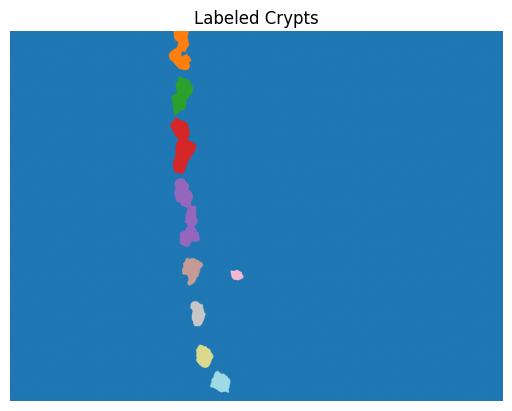

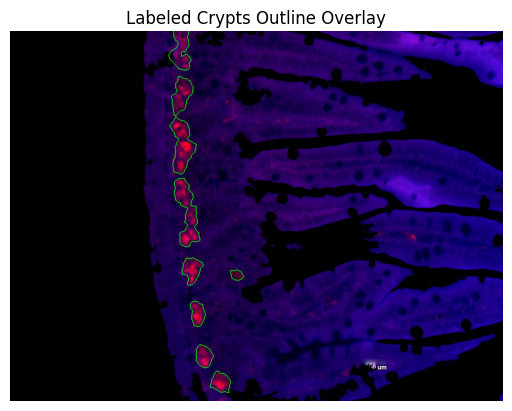

In [2]:
from pathlib import Path
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.stats import entropy as scipy_entropy
from scipy.ndimage import binary_fill_holes

# Cell 0: load and display a TIFF using tifffile

# explicit notebook path (adjust only if your notebook moved)
notebook = Path(r"/home/phillip/documents/lysozyme/ignore/component development/super simplified.ipynb")

# go up to the project folder "lysozyme stain quantification"
project_root = notebook.parent.parent.parent

# construct TIFF path relative to the project root
tif_path = project_root / "lysozyme images" / "Jej LYZ" / "G2" / "G2EL - 3.tif"

if not tif_path.exists():
    raise FileNotFoundError(f"TIFF not found: {tif_path.resolve()}")

def remove_rectangles( image, white_thresh=240, aspect_low=0.2, aspect_high=5.0,
                        dilation_kernel=(15, 15), inpaint_radius=15):
    """Remove rectangular artifacts from image."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if image.ndim == 3 else image
    _, bm = cv2.threshold(gray, white_thresh, 255, cv2.THRESH_BINARY)
    cnts, _ = cv2.findContours(bm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w == 0 or h == 0: 
            continue
        ar = w / h
        if ar < aspect_low or ar > aspect_high:
            cv2.rectangle(mask, (x, y), (x+w, y+h), 255, -1)
            
    if not mask.any(): 
        return image.copy()
    mask = cv2.dilate(mask, np.ones(dilation_kernel, np.uint8), 1)
    bgr = image[..., ::-1]
    out = cv2.inpaint(bgr, mask, inpaint_radius, cv2.INPAINT_TELEA)
    return out[..., ::-1]

img = remove_rectangles(tifffile.imread(tif_path))  # loads numpy array

# compute Otsu threshold on a grayscale version, erode the mask and hole-fill it, then zero-out background pixels in img

# make a grayscale copy (match the conversion used later so variables stay consistent)
if img.ndim == 3 and img.shape[-1] in (3, 4):
    gray = cv2.cvtColor(img[..., :3], cv2.COLOR_RGB2GRAY)
else:
    gray = np.squeeze(img) if img.ndim >= 2 else img.copy()

gray_u8 = gray.astype(np.uint8)
otsu_thresh, _ = cv2.threshold(gray_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# initial binary mask (foreground True)
mask = gray_u8 > otsu_thresh

# erode the mask to remove small spurious foreground pixels
ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_eroded = cv2.erode((mask.astype(np.uint8) * 255), ker, iterations=1).astype(bool)

# fill holes in the eroded mask
mask_filled = binary_fill_holes(mask_eroded)

# update mask to the processed version
mask = mask_filled

# set background (where mask is False) to zero in the original img array
if img.ndim == 3 and img.shape[-1] in (3, 4):
    img[~mask] = 0
else:
    img[~mask] = 0
if img.ndim == 3 and img.shape[-1] in (3, 4):
    gray = cv2.cvtColor(img[..., :3], cv2.COLOR_RGB2GRAY)
else:
    gray = np.squeeze(img) if img.ndim >= 2 else img.copy()

# gray_u8 = gray.astype(np.uint8)
# otsu_thresh, _ = cv2.threshold(gray_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# mask = gray_u8 > otsu_thresh  # foreground True

# # set background (where mask is False) to zero in the original img array
# if img.ndim == 3 and img.shape[-1] in (3, 4):
#     img[~mask] = 0
# else:
#     img[~mask] = 0

print(f"Otsu threshold = {otsu_thresh}")
plt.imshow(img)

# extract channels (assuming img is HxWx3 in RGB order)
from skimage.morphology import reconstruction
red_ch = img[..., 0]
blue_ch = img[..., 2]


marker_r = red_ch.astype(np.float32)
other_r = blue_ch.astype(np.float32)
mask_r_dilation = np.maximum(other_r, marker_r)
mask_r_erosion  = np.minimum(other_r, marker_r)

# morphological reconstructions

recon_d_red  = reconstruction(marker_r, mask_r_dilation, method="dilation")
recon_e_red  = reconstruction(marker_r, mask_r_erosion,  method="erosion")


recon_d_red_u8  = np.clip(recon_d_red,  0, 255).astype(np.uint8)
recon_e_red_u8  = np.clip(recon_e_red,  0, 255).astype(np.uint8)

import numpy as np
from skimage.segmentation import expand_labels, watershed, find_boundaries
from scipy.ndimage import label as ndi_label, distance_transform_edt


import numpy as np


from skimage import morphology

# extract channels (assuming img is HxWx3 in RGB order)
red_ch = img[..., 0]

diff_r =  red_ch.astype(int) > recon_e_red_u8.astype(int)
diff_r = morphology.remove_small_objects(morphology.binary_erosion(diff_r, footprint=np.ones((3, 3))), min_size=100)



def minmax01(x, axis=None, eps=1e-12):
    x = np.asarray(x, dtype=float)
    lo = np.nanmin(x, axis=axis, keepdims=True)
    hi = np.nanmax(x, axis=axis, keepdims=True)
    return (x - lo) / np.maximum(hi - lo, eps)



# create boolean mask where abs(dilation - red) > red
abs_diff = np.abs(recon_d_red_u8.astype(int) - red_ch.astype(int))
mask_gt_red = abs_diff > red_ch.astype(int)

# quick stats
n_pixels = mask_gt_red.size
n_true = int(mask_gt_red.sum())


# erode the binary mask a bit to "shrink it back"
erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
erosion_iters = 2  # adjust if you want stronger/weaker erosion

# prepare uint8 mask for morphological ops
mask_u8 = (mask_gt_red.astype(np.uint8) * 255)
mask_eroded_u8 = cv2.erode(mask_u8, erosion_kernel, iterations=erosion_iters)
mask_gt_red_eroded = mask_eroded_u8.astype(bool)


from scipy.ndimage import distance_transform_edt

# Combine diff_r and mask_gt_red into a labeled numpy array
combined_labels = np.zeros_like(diff_r, dtype=int)

# Assign unique labels to diff_r and mask_gt_red
combined_labels[mask_gt_red_eroded] = 2  # Label for mask_gt_red
combined_labels[diff_r] = 1       # Label for diff_r (takes precedence)

# --- helpers ---
def minmax01(x, eps=1e-12):
    x = x.astype(float, copy=False)
    lo = np.min(x)
    hi = np.max(x)
    return (x - lo) / max(hi - lo, eps)

# expand combined labels (0=bg, 1=classA, 2=classB e.g.)
expanded_labels = expand_labels(combined_labels, distance=100)

# markers from diff_r (0 = not a marker)
labeled_crypts, _ = ndi_label(expanded_labels == 1)
plt.imshow(labeled_crypts, cmap="tab20")
plt.title("Labeled Crypts") 
plt.axis("off")
plt.show()

from skimage.segmentation import find_boundaries

# Find the boundaries of the labeled crypts
crypts_boundaries = find_boundaries(labeled_crypts, mode='thick')

# Define a color for the boundaries (bright green)
boundary_color = [0, 255, 0]  # RGB for bright green

# Overlay the boundaries on the original image
img_outline_overlay = img.copy()
img_outline_overlay[crypts_boundaries] = boundary_color

# Display the result
plt.imshow(img_outline_overlay)
plt.title("Labeled Crypts Outline Overlay")
plt.axis("off")
plt.show()

In [ ]:
# Cell 1 (updated): Batch process up to 30 RFP/DAPI channel pairs.
from skimage.morphology import reconstruction
from skimage import morphology
from skimage.segmentation import expand_labels, find_boundaries
from scipy.ndimage import label as ndi_label, binary_fill_holes
import tifffile, numpy as np, cv2, math
from pathlib import Path

images_root = project_root / 'lysozyme images'
red_files = sorted(list(images_root.rglob('*_RFP.tif')) + list(images_root.rglob('*_RFP.tiff')))

def match_blue(r_path: Path):
    stem = r_path.name
    # remove trailing _RFP before extension
    if '_RFP.' not in stem:
        return None
    base = stem.split('_RFP.')[0]
    for ext in ['tif','tiff','TIF','TIFF']:
        cand = r_path.with_name(f'{base}_DAPI.{ext}')
        if cand.exists():
            return cand
    return None

pairs = []
for r in red_files:
    b = match_blue(r)
    if b is not None:
        pairs.append((r,b))
    if len(pairs) >= 30:
        break

print(f'Found {len(red_files)} red candidates; using {len(pairs)} paired RFP/DAPI images.')
if not pairs:
    print('No channel pairs found (expect *_RFP + *_DAPI).')

def load_as_gray(p: Path):
    arr = tifffile.imread(p)
    if arr.ndim == 3:
        # if channel-first or channel-last multi-channel, pick first channel as intensity
        if arr.shape[0] <= 4 and arr.shape[0] < arr.shape[-1]:
            arr = np.moveaxis(arr, 0, -1)
        if arr.shape[-1] in (3,4):
            arr = cv2.cvtColor(arr[..., :3].astype(np.uint8), cv2.COLOR_RGB2GRAY)
        else:
            arr = arr[...,0]
    return arr.astype(np.float32)

def build_rgb(red_gray, blue_gray):
    # normalize to 0-255 independently (avoid overflow if already 8-bit).
    def to_u8(x):
        if x.dtype != np.uint8:
            lo, hi = np.nanmin(x), np.nanmax(x)
            if hi > lo:
                x = (x - lo)/(hi-lo)*255.0
            else:
                x = np.zeros_like(x)
            return x.astype(np.uint8)
        return x
    r8 = to_u8(red_gray)
    b8 = to_u8(blue_gray)
    zeros = np.zeros_like(r8)
    return np.stack([r8, zeros, b8], axis=-1)

def process_pair(r_path: Path, b_path: Path):
    try:
        r = load_as_gray(r_path)
        b = load_as_gray(b_path)
    except Exception as e:
        print(f'[skip] read error {r_path.name}/{b_path.name}: {e}')
        return None
    if r.shape != b.shape:
        print(f'[skip] shape mismatch {r.shape} vs {b.shape}: {r_path.name}')
        return None
    rgb = build_rgb(r, b)
    # optional rectangle removal (acts per-channel); keep if bright artifacts exist
    try:
        rgb = remove_rectangles(rgb)
    except Exception:
        pass
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    gray_u8 = gray.astype(np.uint8)
    otsu, _ = cv2.threshold(gray_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = gray_u8 > otsu
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.erode((mask.astype(np.uint8)*255), ker, iterations=1).astype(bool)
    mask = binary_fill_holes(mask)
    rgb[~mask] = 0
    red = rgb[...,0].astype(np.float32)
    blue = rgb[...,2].astype(np.float32)
    marker_r = red
    other_r  = blue
    mask_r_dilation = np.maximum(other_r, marker_r)
    mask_r_erosion  = np.minimum(other_r, marker_r)
    recon_d = reconstruction(marker_r, mask_r_dilation, method='dilation')
    recon_e = reconstruction(marker_r, mask_r_erosion,  method='erosion')
    recon_d_u8 = np.clip(recon_d,0,255).astype(np.uint8)
    recon_e_u8 = np.clip(recon_e,0,255).astype(np.uint8)
    diff_r = red.astype(int) > recon_e_u8.astype(int)
    diff_r = morphology.binary_erosion(diff_r, footprint=np.ones((3,3)))
    diff_r = morphology.remove_small_objects(diff_r, min_size=100)
    abs_diff = np.abs(recon_d_u8.astype(int) - red.astype(int))
    mask_gt_red = abs_diff > red.astype(int)
    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask_u8 = (mask_gt_red.astype(np.uint8)*255)
    mask_eroded_u8 = cv2.erode(mask_u8, erosion_kernel, iterations=2)
    mask_gt_red_eroded = mask_eroded_u8.astype(bool)
    combined = np.zeros_like(diff_r, dtype=int)
    combined[mask_gt_red_eroded] = 2
    combined[diff_r] = 1
    expanded = expand_labels(combined, distance=100)
    labeled, _ = ndi_label(expanded == 1)
    boundaries = find_boundaries(labeled, mode='thick')
    overlay = rgb.copy()
    overlay[boundaries] = [0,255,0]
    return labeled, overlay, otsu

for idx, (r_fp, b_fp) in enumerate(pairs, 1):
    res = process_pair(r_fp, b_fp)
    if res is None:
        continue
    labeled, overlay, otsu_th = res
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    axes[0].imshow(labeled, cmap='tab20')
    axes[0].set_title('Labeled Crypts')
    axes[0].axis('off')
    axes[1].imshow(overlay)
    axes[1].set_title('Overlay')
    axes[1].axis('off')
    rel_name = r_fp.relative_to(images_root).as_posix().replace('_RFP','')
    fig.suptitle(f'{idx:02d}: {rel_name}  (Otsu={otsu_th})', fontsize=9)
    plt.tight_layout()
    plt.show()

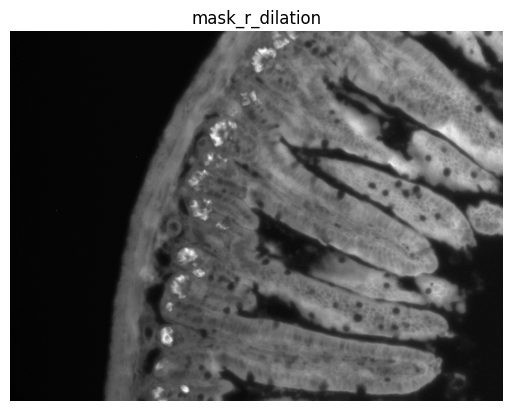

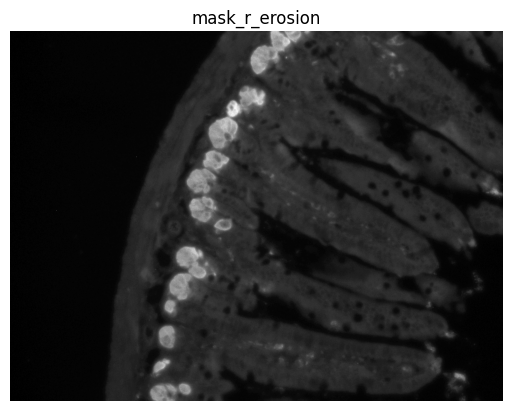

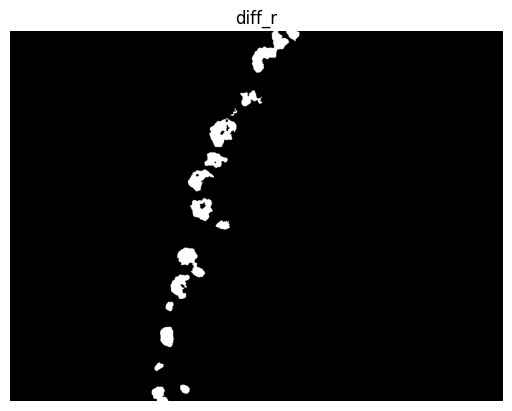

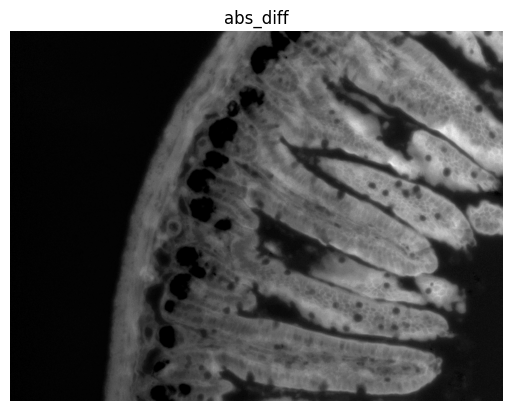

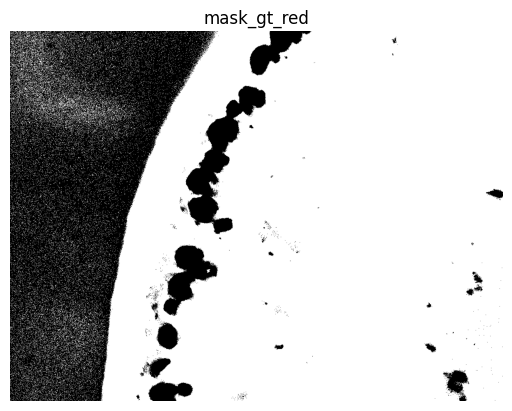

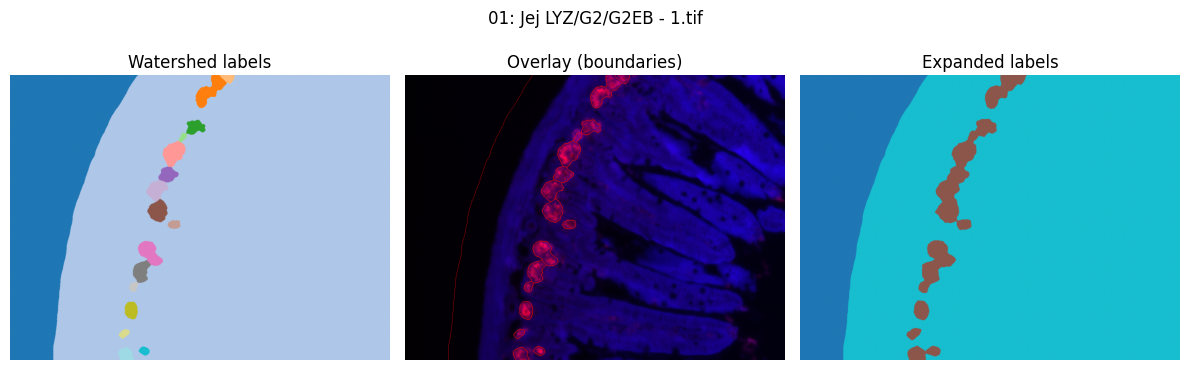

In [3]:
# Cell 2: Watershed refinement using expanded labels over RFP/DAPI pairs
import numpy as np
from skimage.segmentation import expand_labels, watershed, find_boundaries
from scipy.ndimage import label as ndi_label, distance_transform_edt
import tifffile, cv2
from pathlib import Path
from skimage import morphology

# Reuse existing 'pairs' if created earlier; otherwise build it quickly.
if 'pairs' not in globals():
    images_root = project_root / 'lysozyme images'
    red_files = sorted(list(images_root.rglob('*_RFP.tif')) + list(images_root.rglob('*_RFP.tiff')))
    def _match_blue(r_path: Path):
        stem = r_path.name
        if '_RFP.' not in stem:
            return None
        base = stem.split('_RFP.')[0]
        for ext in ['tif','tiff','TIF','TIFF']:
            cand = r_path.with_name(f'{base}_DAPI.{ext}')
            if cand.exists():
                return cand
        return None
    pairs = []
    for _r in red_files:
        b = _match_blue(_r)
        if b is not None:
            pairs.append((_r,b))
        if len(pairs) >= 30:
            break
    if not pairs:
        print('No RFP/DAPI pairs found. Aborting watershed cell.')

# Helper loaders (reuse if already defined).
if 'load_as_gray' not in globals():
    def load_as_gray(p: Path):
        arr = tifffile.imread(p)
        if arr.ndim == 3:
            if arr.shape[0] <= 4 and arr.shape[0] < arr.shape[-1]:
                arr = np.moveaxis(arr, 0, -1)
            if arr.shape[-1] in (3,4):
                arr = cv2.cvtColor(arr[..., :3].astype(np.uint8), cv2.COLOR_RGB2GRAY)
            else:
                arr = arr[...,0]
        return arr.astype(np.float32)
if 'build_rgb' not in globals():
    def build_rgb(red_gray, blue_gray):
        def to_u8(x):
            if x.dtype != np.uint8:
                lo, hi = np.nanmin(x), np.nanmax(x)
                if hi > lo:
                    x = (x - lo)/(hi-lo)*255.0
                else:
                    x = np.zeros_like(x)
                return x.astype(np.uint8)
            return x
        r8 = to_u8(red_gray)
        b8 = to_u8(blue_gray)
        zeros = np.zeros_like(r8)
        return np.stack([r8, zeros, b8], axis=-1)

# Provided helper: minmax01
def minmax01(x, eps=1e-12):
    x = x.astype(float, copy=False)
    lo = np.min(x)
    hi = np.max(x)
    return (x - lo) / max(hi - lo, eps)

max_show = 1  # limit visualization
for idx, (r_fp, b_fp) in enumerate(pairs[:max_show], 1):
    try:
        r = load_as_gray(r_fp)
        b = load_as_gray(b_fp)
    except Exception as e:
        print(f'[skip] read error {r_fp.name}/{b_fp.name}: {e}')
        continue
    if r.shape != b.shape:
        print(f'[skip] shape mismatch {r.shape} vs {b.shape}: {r_fp.name}')
        continue
    disp = build_rgb(r, b)
    try:
        disp = remove_rectangles(disp)
    except Exception:
        pass

    # Red / Blue channels for logic
    red = disp[...,0].astype(np.float32)
    blue = disp[...,2].astype(np.float32)

    # Simple morphological reconstruction style differences (reuse earlier approach)
    mask_r_dilation = np.maximum(blue, red)
    plt.imshow(mask_r_dilation, cmap='gray'); plt.title('mask_r_dilation'); plt.axis('off'); plt.show()
    mask_r_erosion  = np.minimum(blue, red)
    plt.imshow(mask_r_erosion, cmap='gray'); plt.title('mask_r_erosion'); plt.axis('off'); plt.show()
    # Keep lightweight (no explicit recon here if not imported); fall back to raw comparisons:
    # diff_r: red stronger than min envelope (using simple comparison as placeholder for recon_e).
    diff_r = red > blue #mask_r_erosion
  
    diff_r = morphology.binary_erosion(diff_r, footprint=np.ones((3,3)))
    diff_r = morphology.remove_small_objects(diff_r, min_size=100)
    plt.imshow(diff_r, cmap='gray'); plt.title('diff_r'); plt.axis('off'); plt.show()
    # Secondary mask (analogous to mask_gt_red) using absolute difference with 'dilation' surrogate
    abs_diff = np.abs(mask_r_dilation - red)
    plt.imshow(abs_diff, cmap='gray'); plt.title('abs_diff'); plt.axis('off'); plt.show()
    mask_gt_red = abs_diff > red
    plt.imshow(mask_gt_red, cmap='gray'); plt.title('mask_gt_red'); plt.axis('off'); plt.show()
    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6))
    mask_u8 = (mask_gt_red.astype(np.uint8)*255)
    mask_eroded_u8 = cv2.erode(mask_u8, erosion_kernel, iterations=2)
    mask_gt_red_eroded = mask_eroded_u8.astype(bool)

    # Build combined_labels (0 bg, 1 diff_r, 2 mask_gt_red)
    combined_labels = np.zeros_like(diff_r, dtype=int)
    combined_labels[mask_gt_red_eroded] = 2
    combined_labels[diff_r] = 1

    # Expand labels
    expanded_labels = expand_labels(combined_labels, distance=100)

    # Markers from diff_r
    labeled_diff_r, _ = ndi_label(diff_r != 0)

    # Reworked markers array
    reworked = np.zeros_like(expanded_labels, dtype=np.int32)
    reworked[expanded_labels == 2] = 1  # entire class 2 region => marker 1
    mask_copy = (expanded_labels != 2) & (labeled_diff_r != 0)
    reworked[mask_copy] = labeled_diff_r[mask_copy] + 1

    # Watershed mask
    mask_ws = expanded_labels > 0

    # Elevation: attract to class 2, repel from class 1
    elevation = (
        minmax01(distance_transform_edt(combined_labels == 2))
        - minmax01(distance_transform_edt(combined_labels == 1))
    )

    ws_labels = watershed(elevation, markers=reworked, mask=mask_ws)

    # Visual overlay
    boundaries = find_boundaries(ws_labels, mode='inner')
    overlay_ws = disp.copy()
    overlay_ws[boundaries] = [255, 0, 0]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(ws_labels, cmap='tab20'); plt.title('Watershed labels'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(overlay_ws); plt.title('Overlay (boundaries)'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(expanded_labels, cmap='tab10'); plt.title('Expanded labels'); plt.axis('off')
    rel_name = r_fp.relative_to(project_root / 'lysozyme images').as_posix().replace('_RFP','')
    plt.suptitle(f'{idx:02d}: {rel_name}')
    plt.tight_layout()
    plt.show()

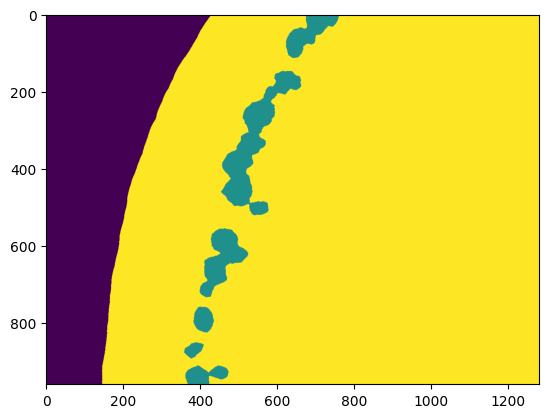

In [7]:
plt.imshow(expanded_labels)